# Train u-net segmentation model with fastai & pytorch

In [49]:
import torch; print(torch.__version__)

1.2.0


In [50]:
import fastai; fastai.__version__

'1.0.59.dev0'

In [51]:
from fastai.vision import *
from fastai.callbacks import *

In [52]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.59.dev0
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7600 / is enabled

=== Hardware === 
nvidia gpus   : 3
torch devices : 3
  - gpu0      : 10988MB | GeForce RTX 2080 Ti
  - gpu1      : 10989MB | GeForce RTX 2080 Ti
  - gpu2      : 10989MB | GeForce RTX 2080 Ti

=== Environment === 
platform      : Linux-5.0.0-31-generic-x86_64-with-debian-buster-sid
distro        : Ubuntu 18.04 bionic
conda env     : fastai-dev
python        : /home/walle/miniconda3/envs/fastai-dev/bin/python
sys.path      : /mnt/963GB/Data/Python/Code/comps/driven_data/caribbean_disaster_risk
/home/walle/miniconda3/envs/fastai-dev/lib/python37.zip
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/lib-dynload

/home/walle/.local/lib/python3.7/site-packages
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-

## Set up data

Now we'll set up our training dataset of tile images and masks created above to load correctly into fastai for training and validation. 

The code in this step tracks closely with that of fastai course's lesson3-camvid so please refer to that [lesson video](https://course.fast.ai/videos/?lesson=3) and [notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb) for more detailed and excellent explanation by Jeremy Howard about the code and fastai's [Data Block API](https://docs.fast.ai/data_block.html).

The main departures from the camvid lesson notebook is the use of filename string parsing to determine which image and mask files comprise the validation data.

And we'll subclass `SegmentationLabelList` to alter the behavior of `open_mask` and `PIL.Image` underlying it in order to open the 3-channel target masks as RGB images `(convert_mode='RGB')` instead of default greyscale 1-channel images `(convert_mode='L')`.

We'll also visually confirm that the image files and channels of the respective target mask file are loaded and paired correctly with a display function `show_3ch`.

In [53]:
path = Path('data')
path.ls()

[PosixPath('data/guatemala_mixco_1_images-256'),
 PosixPath('data/train_labels.csv'),
 PosixPath('data/st_lucia_gros_islet_images-256'),
 PosixPath('data/st_lucia_gros_islet_masks-256'),
 PosixPath('data/metadata.csv'),
 PosixPath('data/colombia_borde_rural_masks-256'),
 PosixPath('data/colombia_borde_rural_images-256'),
 PosixPath('data/guatemala_mixco_3_images-256'),
 PosixPath('data/stac.tar'),
 PosixPath('data/st_lucia_dennery_images-256'),
 PosixPath('data/guatemala_mixco_1_masks-256'),
 PosixPath('data/stac'),
 PosixPath('data/colombia_borde_soacha_masks-256'),
 PosixPath('data/colombia_borde_soacha_images-256'),
 PosixPath('data/st_lucia_castries_masks-256'),
 PosixPath('data/st_lucia_castries_images-256'),
 PosixPath('data/submission_format.csv'),
 PosixPath('data/tiles'),
 PosixPath('data/guatemala_mixco_3_masks-256'),
 PosixPath('data/st_lucia_dennery_masks-256')]

In [54]:
tile_size = 256
zoom_level = 19

In [55]:
size = 256
bs = 16

In [56]:
COUNTRY='colombia'
REGION='borde_soacha'

In [57]:
path_lbl = path/f'{COUNTRY}_{REGION}_masks-{tile_size}'
path_img = path/f'{COUNTRY}_{REGION}_images-{tile_size}'

In [58]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
print(len(fnames), len(lbl_names))
fnames[:3], lbl_names[:3] 

238 238


([PosixPath('data/colombia_borde_soacha_images-256/colombia_borde_soacha_001trn_19_154130_255485.png'),
  PosixPath('data/colombia_borde_soacha_images-256/colombia_borde_soacha_001trn_19_154122_255477.png'),
  PosixPath('data/colombia_borde_soacha_images-256/colombia_borde_soacha_001trn_19_154127_255481.png')],
 [PosixPath('data/colombia_borde_soacha_masks-256/colombia_borde_soacha_001trn_19_154124_255487_mask.png'),
  PosixPath('data/colombia_borde_soacha_masks-256/colombia_borde_soacha_001trn_19_154125_255488_mask.png'),
  PosixPath('data/colombia_borde_soacha_masks-256/colombia_borde_soacha_001trn_19_154130_255481_mask.png')])

In [59]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_mask.png'

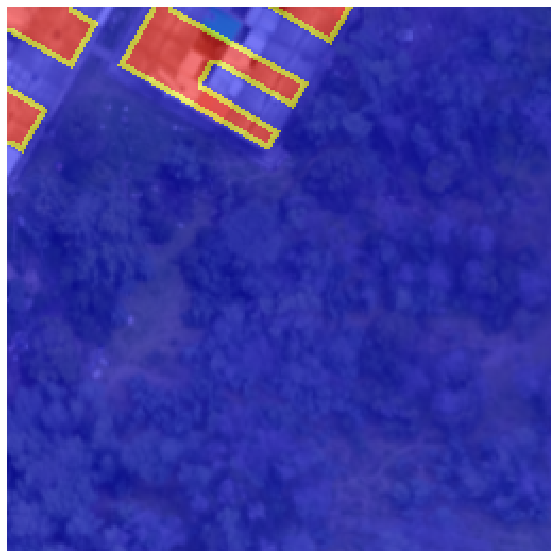

In [60]:
# test that masks are opening correctly with open_mask() settings
img_f = fnames[10]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

(array([129791.,      0.,  66817.]),
 array([  0.,  85., 170., 255.]),
 <a list of 3 Patch objects>)

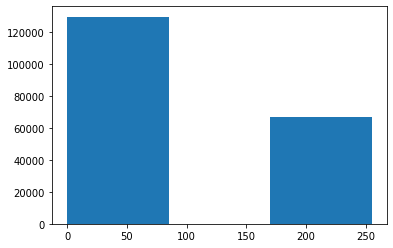

In [61]:
plt.hist(mask.data.view(-1), bins=3)

In [62]:
# define the valdation set by fn prefix
holdout_grids = [f'{COUNTRY}_{REGION}_001val_']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]
print(len(valid_idx))

20


In [63]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True, convert_mode='RGB') for 3 channel target masks

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [64]:
# the classes corresponding to each channel
codes = np.array(['Footprint','Boundary','Contact'])

In [65]:
# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

src = (SegItemListCustom.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=codes))

data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [66]:
def show_3ch(imgitem, figsize=(10,5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=figsize)
    ax1.imshow(np.asarray(imgitem.data[0,None])[0])
    ax2.imshow(np.asarray(imgitem.data[1,None])[0])
    ax3.imshow(np.asarray(imgitem.data[2,None])[0])
    
    ax1.set_title('Footprint')
    ax2.set_title('Boundary')
    ax3.set_title('Contact')
    
    plt.show()

colombia_borde_soacha_001val_19_154130_255484.png


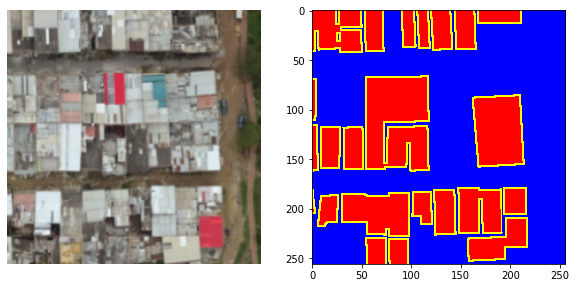

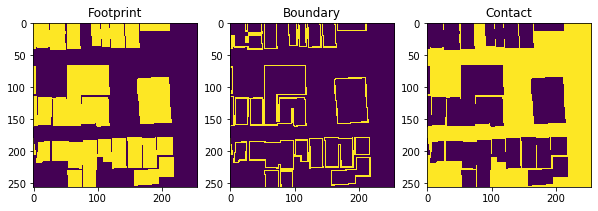

colombia_borde_soacha_001val_19_154137_255484.png


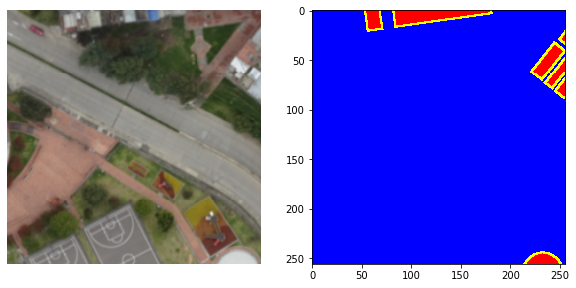

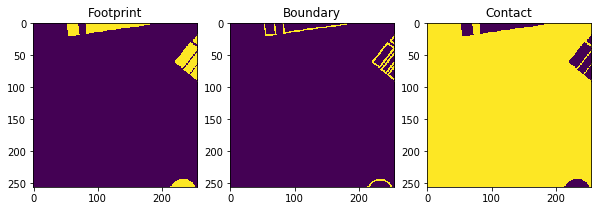

colombia_borde_soacha_001val_19_154116_255475.png


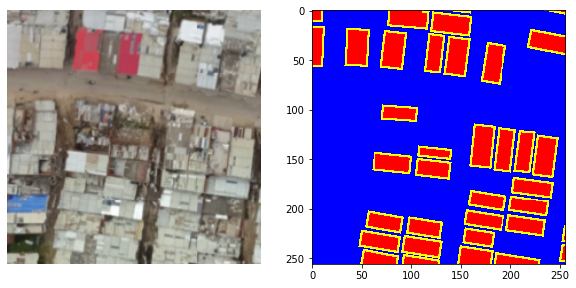

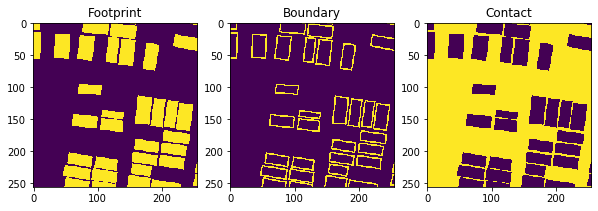

colombia_borde_soacha_001val_19_154123_255475.png


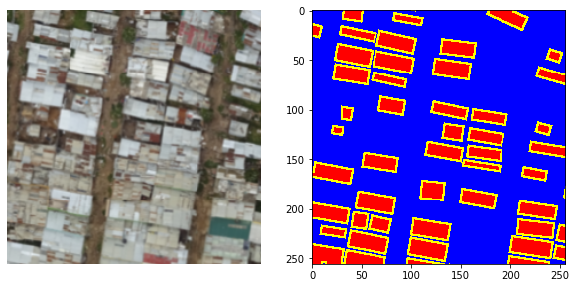

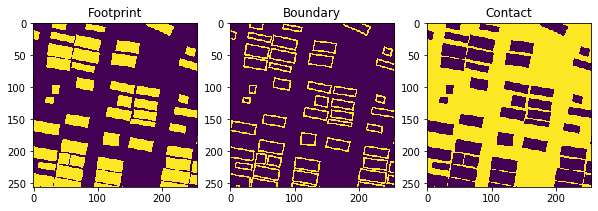

colombia_borde_soacha_001val_19_154121_255474.png


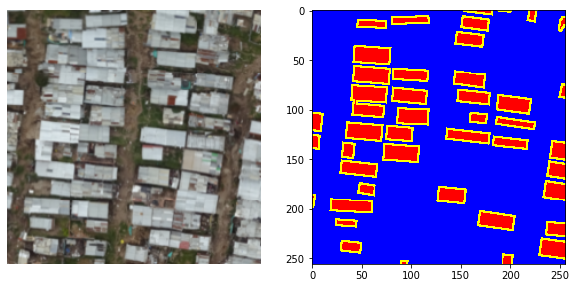

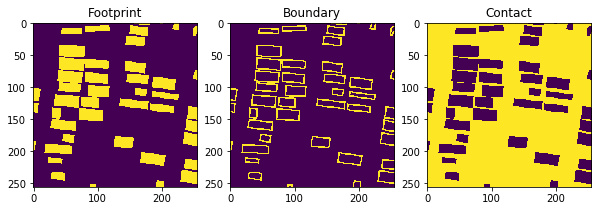

In [67]:
for idx in range(0,5):
    print(data.valid_ds.items[idx].name)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    data.valid_ds.x[idx].show(ax=ax1)
    ax2.imshow(image2np(data.valid_ds.y[idx].data*255))
    plt.show()
    show_3ch(data.valid_ds.y[idx])

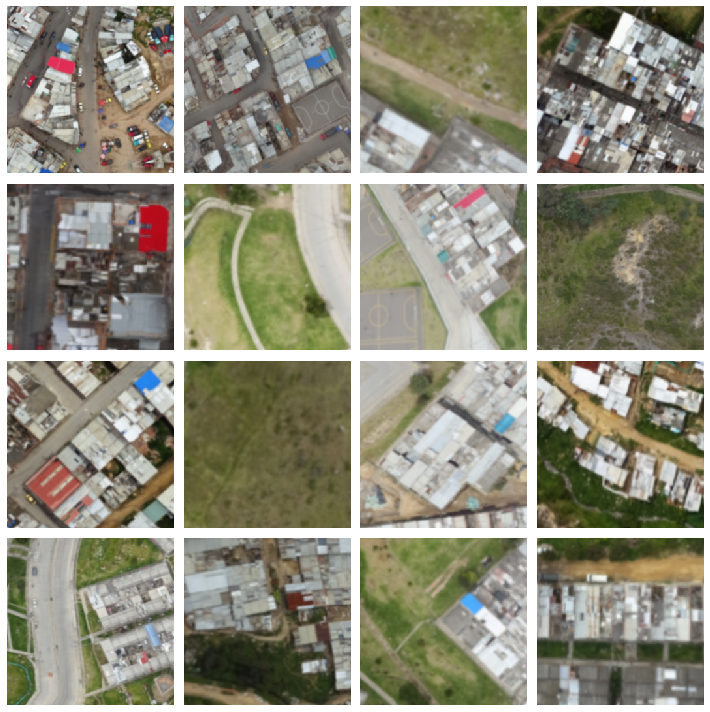

In [68]:
# visually inspect data-augmented training images
# TODO: show_batch doesn't display RGB mask correctly, setting alpha=0 to turn off for now
data.show_batch(4,figsize=(10,10), alpha=0.)

In [69]:
data

ImageDataBunch;

Train: LabelList (218 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256)
Path: data/colombia_borde_soacha_images-256;

Valid: LabelList (20 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256)
Path: data/colombia_borde_soacha_images-256;

Test: None

## Define custom losses and metrics to handle 3-channel targets

Here we implement some new loss functions like Dice Loss and Focal Loss which have been shown to perform well in image segmentation tasks. Then we'll create a `MultiChComboLoss` class to combine multiple loss functions and  calculate them across the 3 channels with adjustable weighting.

The approach of combining a Dice or Jaccard loss to consider image-wide context with individual pixel-focused Binary Cross Entropy or Focal loss with adjustable weighing of the 3 target mask channels has been shown to consistently outperform single loss functions. This is well-documented by Nick Weir's deep dive into the recent [SpaceNet 4 Off-Nadir Building Detection](https://spacenetchallenge.github.io/datasets/spacenet-OffNadir-summary.html) top results: 

https://medium.com/the-downlinq/a-deep-dive-into-the-spacenet-4-winning-algorithms-8d611a5dfe25

Finally, we adapt our model evaluation metrics (accuracy and dice score) to calculate a mean score for all channels or by a specified individual channel.

In [70]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

In [71]:
# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

## Set up model

We'll set up fastai's Dynamic Unet model with an ImageNet-pretrained resnet34 encoder. This architecture, inspired by the original U-net, uses by default many advanced deep learning techniques such as:

- One cycle learning schedule: https://sgugger.github.io/the-1cycle-policy.html
- AdamW optimizer: https://www.fast.ai/2018/07/02/adam-weight-decay/
- Pixel shuffle upsampling with ICNR initiation from super resolution research: https://medium.com/@hirotoschwert/introduction-to-deep-super-resolution-c052d84ce8cf
- Optionally set leaky ReLU, blur, self attention: https://docs.fast.ai/vision.models.unet.html#DynamicUnet

We'll define our `MultiChComboLoss` function as a balanced combination of Focal Loss and Dice Loss and set our accuracy and dice metrics. 

Also note that our metrics displayed during training shows channel-0 (building footprint channel only) accuracy and dice metrics in the right-most 2 columns while the first two accuracy and dice metrics (left-hand columns) show the mean of the respective metric across all 3 channels.

In [72]:
# set up metrics to show mean metrics for all channels as well as the building-only metrics (channel 0)

acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [73]:
# combo Focal + Dice loss with equal channel wts

learn = unet_learner(data, models.resnet34, model_dir='models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1,1])
                    )

In [74]:
learn.metrics

[<function __main__.acc_thresh_multich(input: torch.Tensor, target: torch.Tensor, thresh: float = 0.5, sigmoid: bool = True, one_ch: int = None) -> <function NewType.<locals>.new_type at 0x7fee84d57a70>>,
 <function __main__.dice_multich(input: torch.Tensor, targs: torch.Tensor, iou: bool = False, one_ch: int = None) -> <function NewType.<locals>.new_type at 0x7fee84d57a70>>,
 functools.partial(<function acc_thresh_multich at 0x7fee70f0a320>, one_ch=0),
 functools.partial(<function dice_multich at 0x7fee70f0acb0>, one_ch=0)]

In [75]:
learn.loss_func

MultiChComboLoss()

In [76]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

## Train model, inspect results, unfreeze & train more, export for inference

First, we'll fine-tune our Unet on the decoder part only (leaving the weights for the ImageNet-pretrained resnet34 encoder frozen) for some epochs. Then we'll unfreeze all the trainable weights/layers of our model and train for some more epochs.

We'll track the `valid_loss`, `acc_...`, and `dice_..`. metrics per epoch as training progresses to make sure they continue to improve and we're not overfitting. And we set a `SaveModelCallback` which will track the channel-0 dice score, save a model checkpoint each time there's an improvement, and reload the highest performing model checkpoint file at the end of training.

We'll also inspect our model's results by setting `learn.model.eval()`, generating some batches of predictions on the validation set, calculating and reshaping the image-wise loss values, and sorting by highest loss first to see the worst performing results (as measured by the loss which may differ in surprising ways from visually gauging results). 

**Pro-tip:** display and view your results every chance you get! You'll pick up on all kinds of interesting clues about your model's behavior and how to make it better.

Finally, we'll export our trained Unet segmentation model for inference purposes as a `.pkl` file. Learn more about exporting fastai models for inference in this tutorial: https://docs.fast.ai/tutorial.inference.html

In [77]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-07
Min loss divided by 10: 1.91E-03


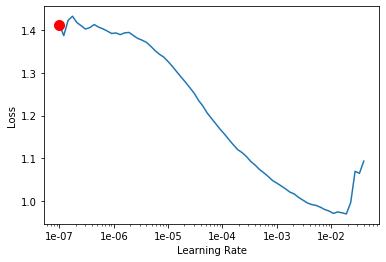

In [78]:
learn.recorder.plot(0,2,suggestion=True)

In [79]:
lr = 1e-3
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name=f'{COUNTRY}_{REGION}_001trn-focaldice-stage1-best')
                    ]
                   )

RuntimeError: Expected object of scalar type Bool but got scalar type Byte for argument #2 'other'

In [ ]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=3,with_loss=True)
losses.shape

In [ ]:
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)
losses_reshaped.shape

In [ ]:
# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:10]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

In [ ]:
learn.load(f'{COUNTRY}_{REGION}_001trn-focaldice-stage1-best')
learn.model.train()
learn.unfreeze()

In [ ]:
learn.lr_find()

Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-05


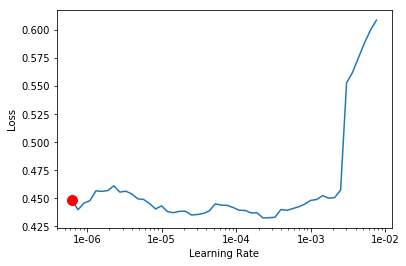

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(20, max_lr=slice(3e-6,3e-4), 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice_multich',
                                           mode='max',
                                           name=f'{COUNTRY}_{REGION}_001trn-focaldice-unfrozen-best')
                    ]
                   )

Better model found at epoch 0 with dice_multich value: 0.849605143070221.
Better model found at epoch 1 with dice_multich value: 0.8512639999389648.
Better model found at epoch 5 with dice_multich value: 0.8526790142059326.
Better model found at epoch 7 with dice_multich value: 0.8566567897796631.
Better model found at epoch 9 with dice_multich value: 0.8609530925750732.
Better model found at epoch 10 with dice_multich value: 0.8626274466514587.
Better model found at epoch 12 with dice_multich value: 0.8664120435714722.
Better model found at epoch 13 with dice_multich value: 0.8684051036834717.
Better model found at epoch 15 with dice_multich value: 0.8700682520866394.


In [0]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=6,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

znz001val_19_319367_270502.png
loss: 0.684914231300354


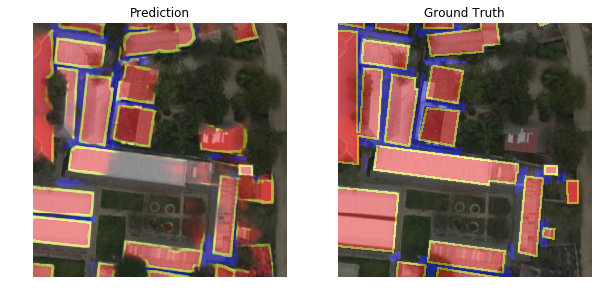

Predicted:


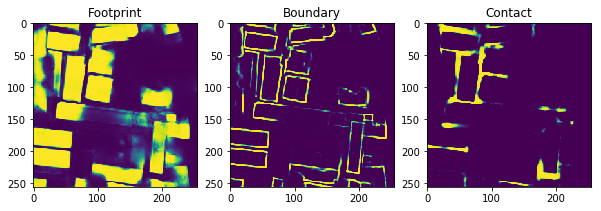

Actual:


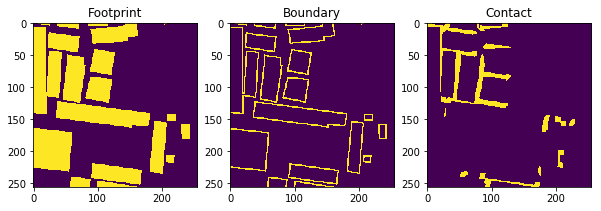

znz001val_19_319372_270506.png
loss: 0.6518591642379761


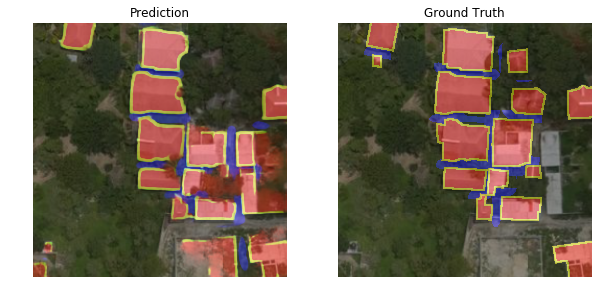

Predicted:


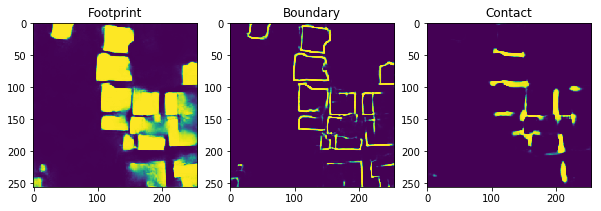

Actual:


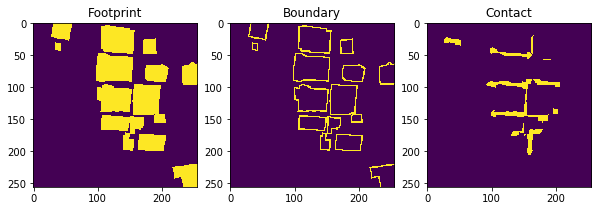

znz001val_19_319367_270498.png
loss: 0.6414041519165039


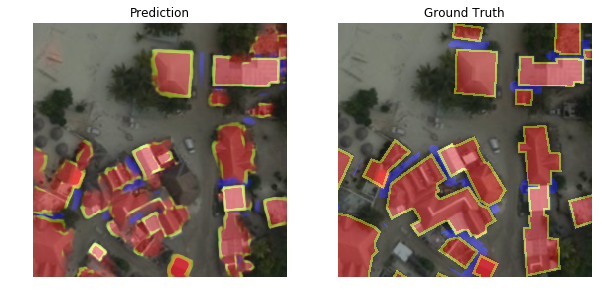

Predicted:


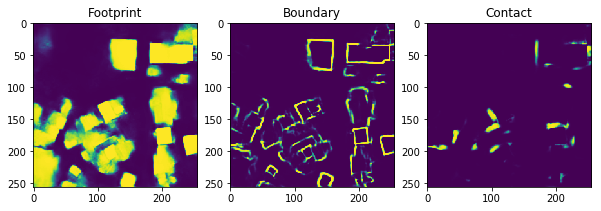

Actual:


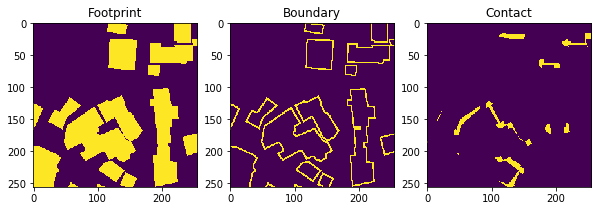

znz001val_19_319372_270501.png
loss: 0.6413131356239319


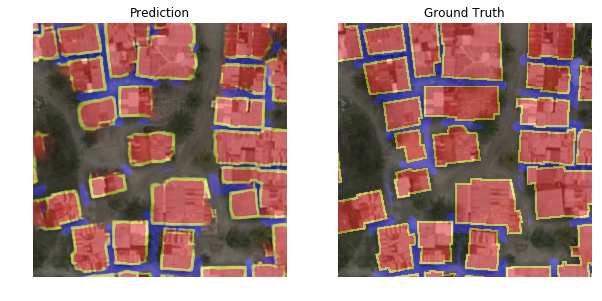

Predicted:


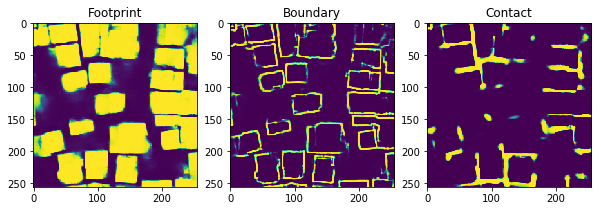

Actual:


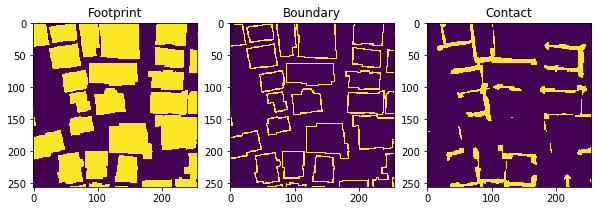

znz001val_19_319373_270506.png
loss: 0.6223063468933105


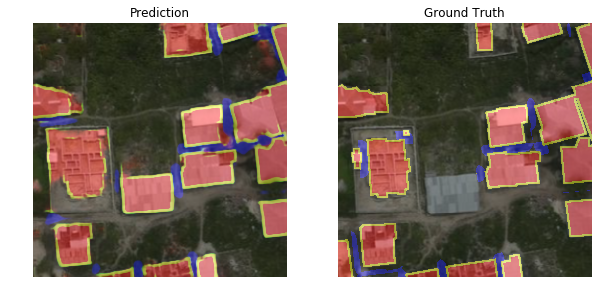

Predicted:


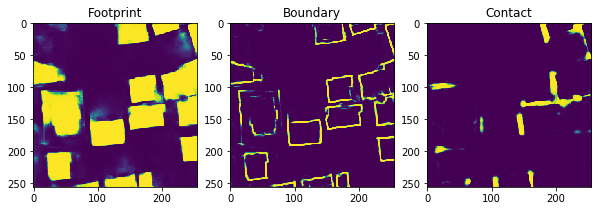

Actual:


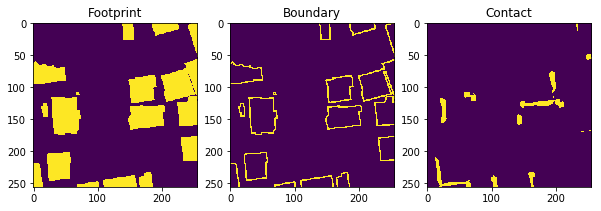

znz001val_19_319367_270503.png
loss: 0.61611008644104


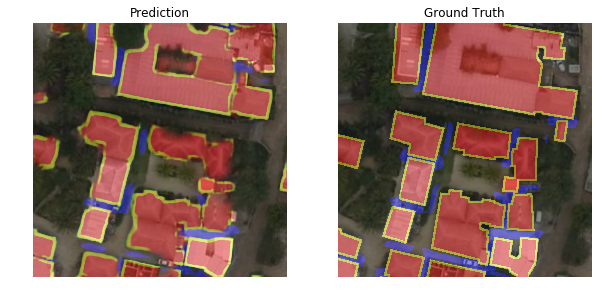

Predicted:


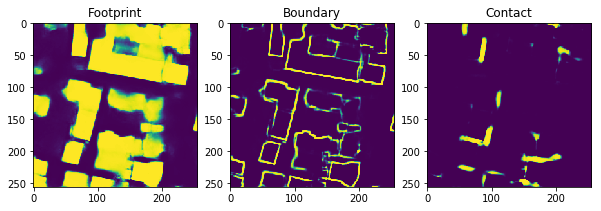

Actual:


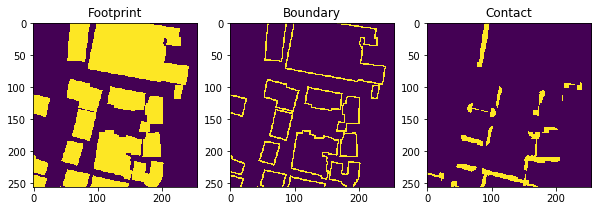

znz001val_19_319376_270499.png
loss: 0.6064223051071167


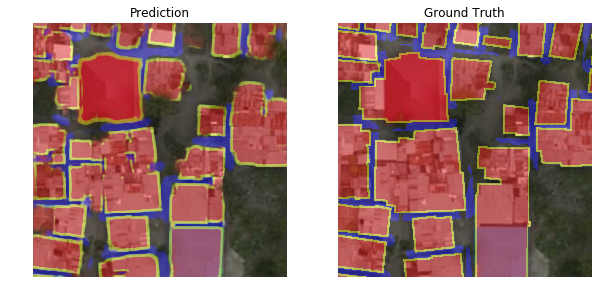

Predicted:


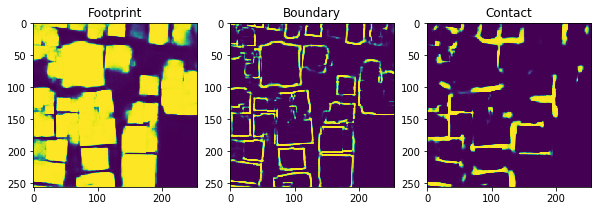

Actual:


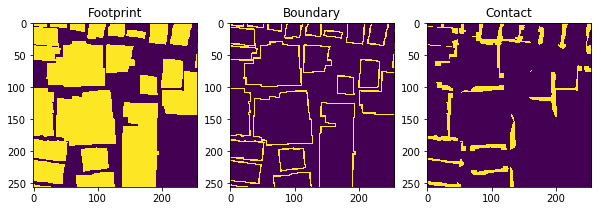

znz001val_19_319368_270514.png
loss: 0.5854003429412842


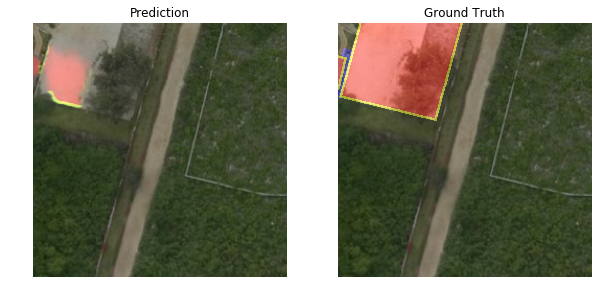

Predicted:


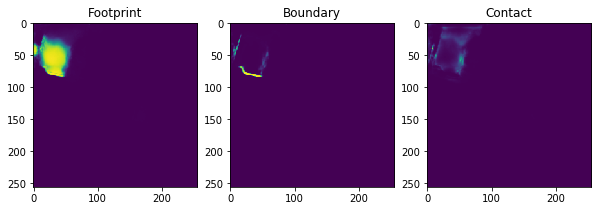

Actual:


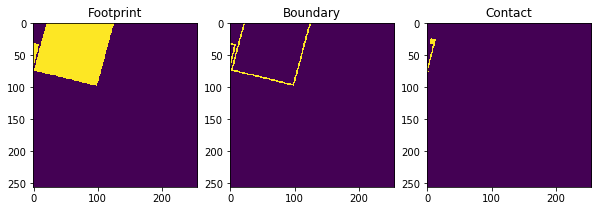

znz001val_19_319375_270513.png
loss: 0.5735171437263489


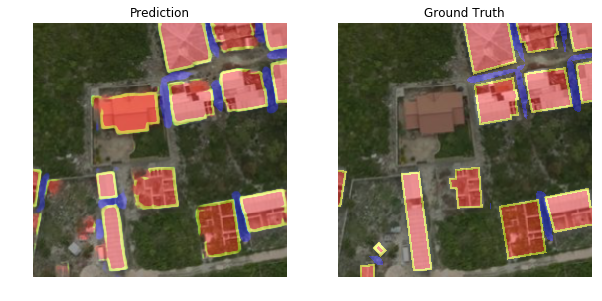

Predicted:


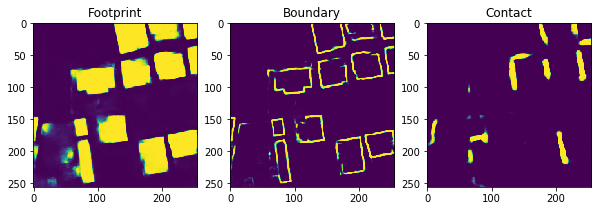

Actual:


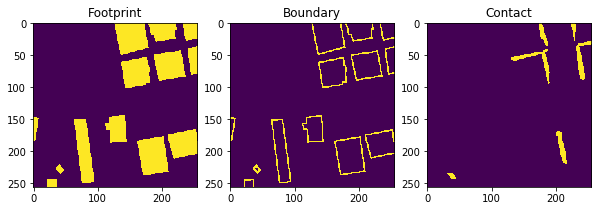

znz001val_19_319377_270506.png
loss: 0.5711398124694824


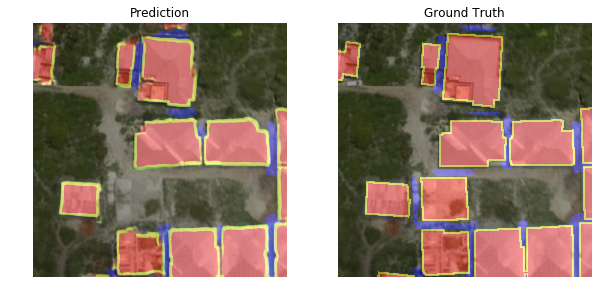

Predicted:


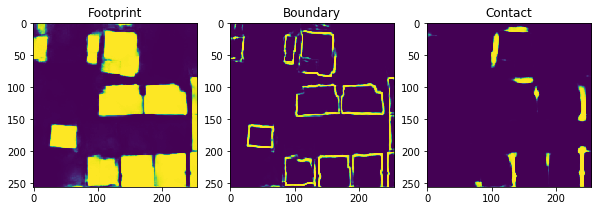

Actual:


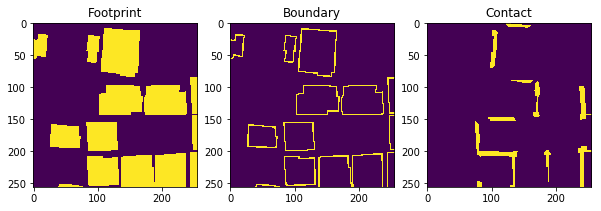

In [0]:
# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:10]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

In [0]:
# pickling with custom classes like MultiChComboLoss is a bit tricky 
learn.export(f'models/{COUNTRY}_{REGION}_001trn-focaldice.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MultiChComboLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DiceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Inference on new imagery

With our segmentation model trained and exported for inference use, we will now re-load it as an inference-only model to test on new unseen imagery. We'll test the generalizability of our trained segmentation model on tiles from drone imagery captured over another part of Zanzibar and in other parts of the world as well as at varying `zoom_levels` (locations and zoom levels indicated):

![](https://cdn-images-1.medium.com/max/1200/1*DaS2dVfeaxZCg6cqOcHDrg.jpeg)

We'll also compare our model inference time per tile on GPU versus CPU.

## Load exported model for inference

In [0]:
from fastai.vision import *
from fastai.callbacks import *

In [0]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python       : 3.6.8
fastai       : 1.0.55
fastprogress : 0.1.21
torch        : 1.1.0
torch cuda   : 10.0.130 / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro       : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env    : Unknown
python       : /usr/bin/python3
sys.path     : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run this utility to get the additional information


In [0]:
# TODO: look into better way of loading export.pkl w/o needing to redefine these custom classes

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [66]:
#!wget -O models/znz001trn-focaldice.pkl https://www.dropbox.com/s/by3nc1xri8y7t4p/znz001trn-focaldice.pkl?dl=1

In [0]:
# if you have your own model .pkl file to load, either:

# upload from computer: Files tab > Upload on left
# or mount GDrive and transfer file to Colab storage: uncomment below, change filepaths to the .pkl file on your GDrive if needed, and run:

# !cp /content/drive/My\ Drive/znz001trn-focaldice.pkl models/

In [0]:
inference_learner = load_learner(path='models/', file='col_borde_rural_001trn-focaldice.pkl')

## Inference on new unseen tiles


In [0]:
import skimage 
import time

def get_pred(learner, tile):
#     pdb.set_trace()
    t_img = Image(pil2tensor(tile[:,:,:3],np.float32).div_(255))
    outputs = learner.predict(t_img)
    im = image2np(outputs[2].sigmoid())
    im = (im*255).astype('uint8')
    return im

In [0]:
# try a different tile by changing or adding your own urls to list

urls = [
  'https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png',
  'https://tiles.openaerialmap.org/5b1e6fd42b6a08001185f7bf/0/5b1e6fd42b6a08001185f7c0/20/569034/537093.png',
  'https://tiles.openaerialmap.org/5beaaba463f9420005ef8db0/0/5beaaba463f9420005ef8db1/19/313479/283111.png',
  'https://tiles.openaerialmap.org/5d050c3673de290005853a91/0/5d050c3673de290005853a92/18/203079/117283.png',
  'https://tiles.openaerialmap.org/5c88ff77225fc20007ab4e26/0/5c88ff77225fc20007ab4e27/21/1035771/1013136.png',
  'https://tiles.openaerialmap.org/5d30bac2e757aa0005951652/0/5d30bac2e757aa0005951653/19/136700/197574.png'
]

### On GPU

https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png
GPU inference took 0.17 secs


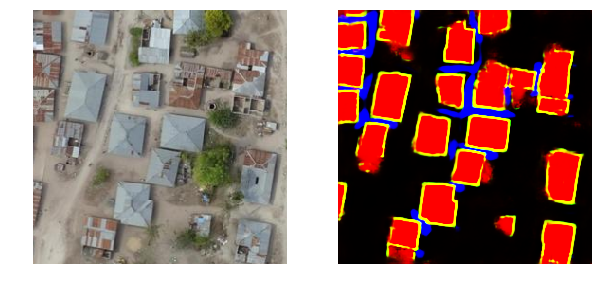

https://tiles.openaerialmap.org/5b1e6fd42b6a08001185f7bf/0/5b1e6fd42b6a08001185f7c0/20/569034/537093.png
GPU inference took 0.18 secs


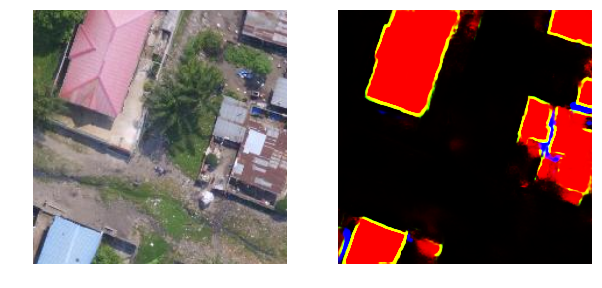

https://tiles.openaerialmap.org/5beaaba463f9420005ef8db0/0/5beaaba463f9420005ef8db1/19/313479/283111.png
GPU inference took 0.18 secs


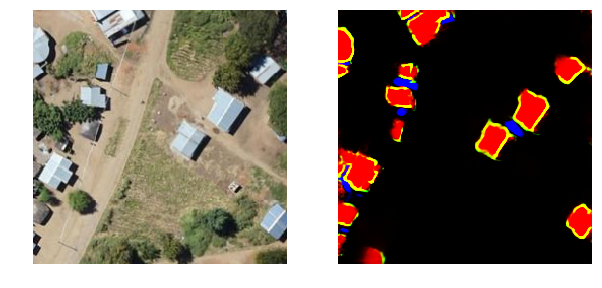

https://tiles.openaerialmap.org/5d050c3673de290005853a91/0/5d050c3673de290005853a92/18/203079/117283.png
GPU inference took 0.17 secs


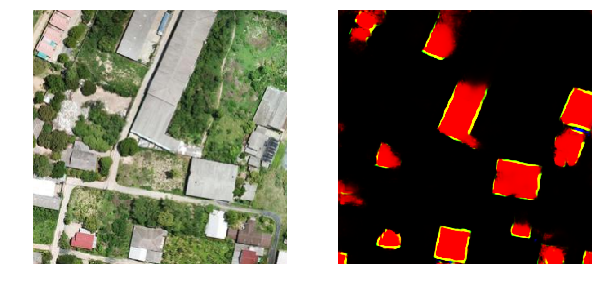

https://tiles.openaerialmap.org/5c88ff77225fc20007ab4e26/0/5c88ff77225fc20007ab4e27/21/1035771/1013136.png
GPU inference took 0.19 secs


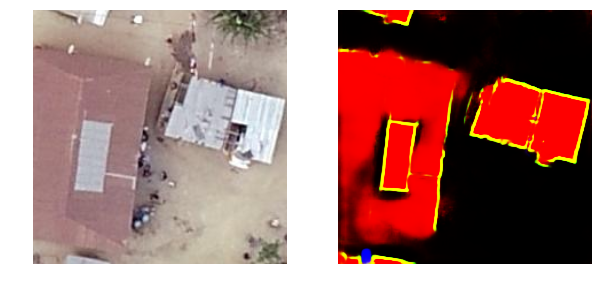

https://tiles.openaerialmap.org/5d30bac2e757aa0005951652/0/5d30bac2e757aa0005951653/19/136700/197574.png
GPU inference took 0.17 secs


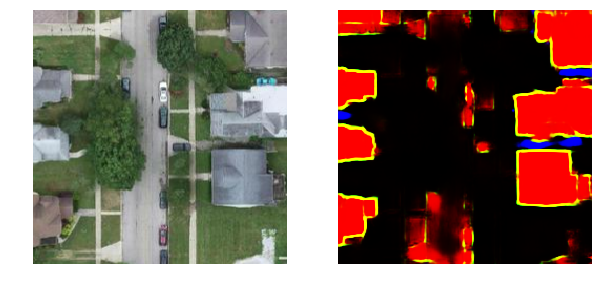

In [0]:
for url in urls:
  t1 = time.time()
  test_tile = skimage.io.imread(url)
  result = get_pred(inference_learner, test_tile)
  t2 = time.time()
  
  print(url)
  print(f'GPU inference took {t2-t1:.2f} secs')
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
  ax1.imshow(test_tile)
  ax2.imshow(result)
  ax1.axis('off')
  ax2.axis('off')
  plt.show()

### On CPU

https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png
CPU inference took 1.58 secs


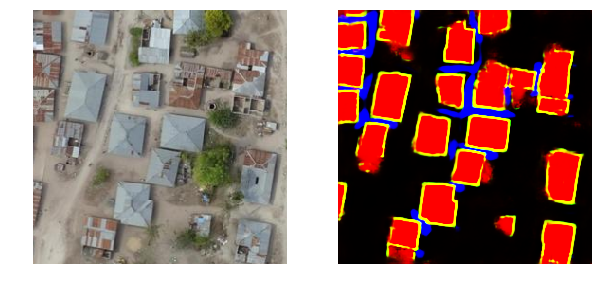

https://tiles.openaerialmap.org/5b1e6fd42b6a08001185f7bf/0/5b1e6fd42b6a08001185f7c0/20/569034/537093.png
CPU inference took 1.60 secs


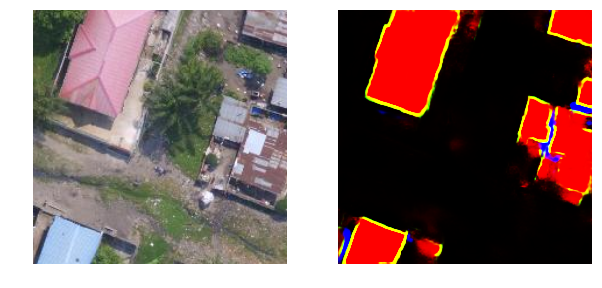

https://tiles.openaerialmap.org/5beaaba463f9420005ef8db0/0/5beaaba463f9420005ef8db1/19/313479/283111.png
CPU inference took 1.58 secs


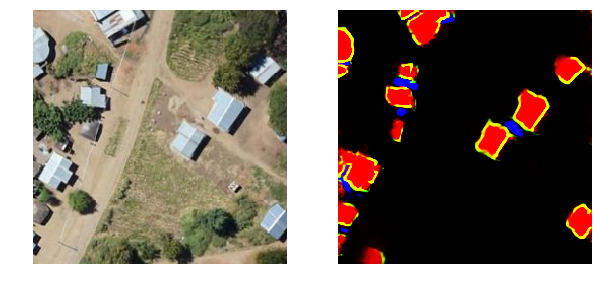

https://tiles.openaerialmap.org/5d050c3673de290005853a91/0/5d050c3673de290005853a92/18/203079/117283.png
CPU inference took 1.60 secs


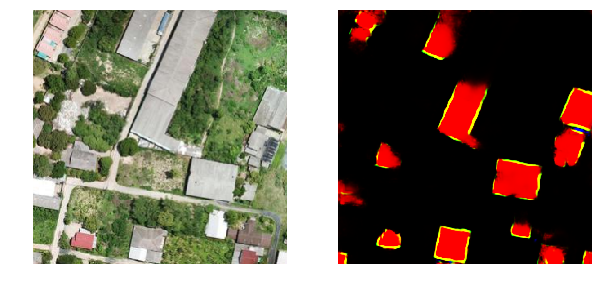

https://tiles.openaerialmap.org/5c88ff77225fc20007ab4e26/0/5c88ff77225fc20007ab4e27/21/1035771/1013136.png
CPU inference took 1.59 secs


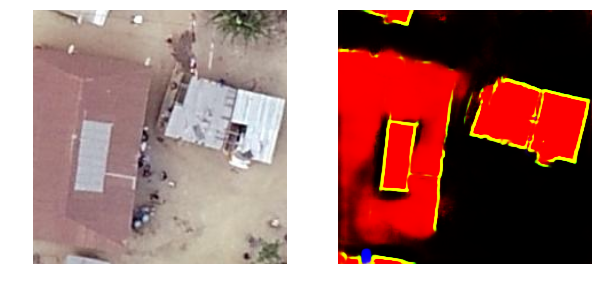

https://tiles.openaerialmap.org/5d30bac2e757aa0005951652/0/5d30bac2e757aa0005951653/19/136700/197574.png
CPU inference took 1.59 secs


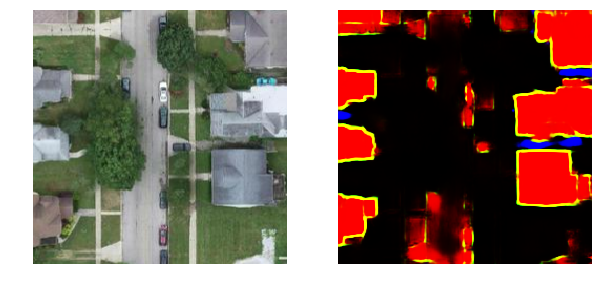

In [0]:
for url in urls:
  t1 = time.time()
  test_tile = skimage.io.imread(url)
  print(url)
  result = get_pred(inference_learner, test_tile)

  t2 = time.time()
  
  print(f'CPU inference took {t2-t1:.2f} secs')
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
  ax1.imshow(test_tile)
  ax2.imshow(result)
  ax1.axis('off')
  ax2.axis('off')
  plt.show()

# Post-processing

## Predict on a tile, threshold, polygonize, and georegister

For good evaluation of model performance against ground truth, we'll use another set of labeled data that the model was not trained on. We'll  get this from the larger Zanzibar dataset. Preview the imagery and ground truth labels for `znz029` in the STAC browser [here](https://geoml-samples.netlify.com/item/9Eiufow7wPXLqQEP1Di2J5X8kXkBLgMsCBoN37VrtRPB/2sEaEKnnyjG2mx7CnN1ESAdjYAEQjoNRxT2vgQRC9oB?si=0&t=preview#14/-5.865178/39.348986):

![](https://cdn-images-1.medium.com/max/1200/0*fGsRIu-2ExIWXzc0)

For demonstration, we'll use this particular tile at `z=19, x=319454, y=270706` from `znz029`:

![alt text](https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png)

Using solaris and geopandas, we'll convert our model's prediction as a 3-channel pixel raster output into a GeoJSON file by:

1. thresholding and combining the 3-channels of pixel values in our raw prediction output into a 1 channel binary pixel mask
2. polygonizing this binary pixel mask into shape vectors representing the predicted footprint of every building
3. georegistering the x, y display coordinates of these vectorized building shapes into longitude, latitude coordinates

In [0]:
# if not already loaded in runtime: 
# install fastai and load inference learner from "Inference on new imagery section" 
# and uncomment below and re-install geo packages

# !add-apt-repository ppa:ubuntugis/ppa
# !apt-get update
# !apt-get install python-numpy gdal-bin libgdal-dev
# !apt install python3-rtree

# !pip install rasterio
# !pip install geopandas
# !pip install descartes
# !pip install solaris
# !pip install rio-tiler

In [0]:
import solaris as sol 
from affine import Affine
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
import math
import geopandas as gpd
import skimage
  
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)
  
def tile_to_poly(z,x,y, size):
    top, left = num2deg(x, y, z)
    bottom, right = num2deg(x+1, y+1, z)
    tfm = from_bounds(left, bottom, right, top, size, size)

    return Polygon.from_bounds(left,top,right,bottom), tfm

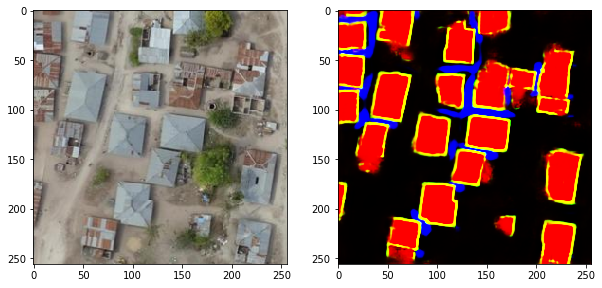

In [0]:
z,x,y = 19,319454,270706
url= 'https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png'

test_tile = skimage.io.imread(url)
result = get_pred(inference_learner, test_tile)
  
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(test_tile)
ax2.imshow(result)
plt.show()

In [0]:
# threshold and polygonize with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_mask_to_vector.html

mask2poly = sol.vector.mask.mask_to_poly_geojson(result, 
                                                 channel_scaling=[1,0,-1], 
                                                 bg_threshold=245, 
                                                 simplify=True,
                                                 tolerance=2
                                                 )

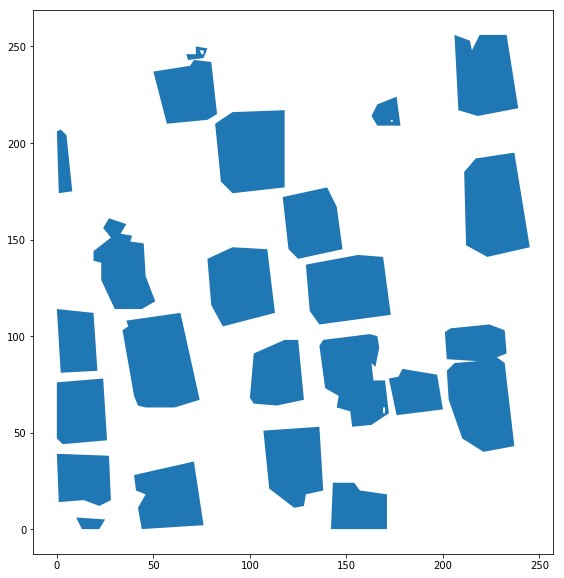

In [0]:
mask2poly.plot(figsize=(10,10))

In [0]:
mask2poly.head()

geometry  value
0           POLYGON ((13 0, 10 6, 25 5, 22 0, 13 0))  255.0
1  POLYGON ((142 0, 143 24, 154 24, 157 20, 171 1...  255.0
2  POLYGON ((44 0, 42 11, 46 18, 41 20, 40 28, 71...  255.0
3  POLYGON ((22 12, 14 15, 1 14, 0 39, 27 38, 28 ...  255.0
4  POLYGON ((123 11, 110 21, 107 51, 136 53, 138 ...  255.0

In [0]:
# get the bounds of the tile and its affine tfm matrix for georegistering purposes
tile_poly, tile_tfm = tile_to_poly(z,x,y,256)
tile_tfm

Affine(2.682209014892578e-06, 0.0, 39.351654052734375,
       0.0, -2.6681491150752634e-06, -5.868769539456524)

In [0]:
# convert polys from pixel coords to geo coords: https://solaris.readthedocs.io/en/latest/api/vector.html?highlight=georegister_px_df#solaris.vector.polygon.georegister_px_df
result_polys = sol.vector.polygon.georegister_px_df(mask2poly, 
                                                   affine_obj=tile_tfm, 
                                                   crs='epsg:4326')

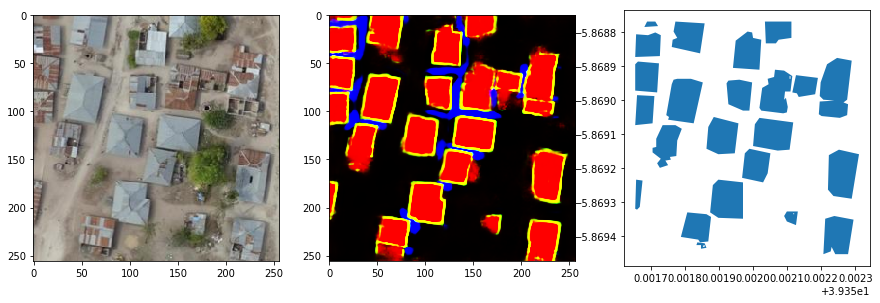

In [0]:
# show tile image to raw prediction to georegistered polygons
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.imshow(test_tile)
ax2.imshow(result)
result_polys.plot(ax=ax3)

In [0]:
result_polys.to_file('result_polys.geojson', driver='GeoJSON')

### Check that the saved result_poly.geojson is correctly georegistered on geojson.io

http://geojson.io/#id=gist:daveluo/3dfe4695e31b2b3a4c7c6e13ada5d1e6&map=19/-5.86910/39.35198

TMS layer link: https://tiles.openaerialmap.org/5ae242fd0b093000130afd38/0/5ae242fd0b093000130afd39/{z}/{x}/{y}.png

![alt text](https://www.dropbox.com/s/kxideja8cx1ao14/check_predicted_polys.png?dl=1)




## Evaluate prediction against ground truth

Finally with georegistered building predictions as a GeoJSON file, we can evaluate it against the ground truth GeoJSON file for the same tile.

We'll clip the ground truth labels to the bounds of this particular tile and use solaris's Evaluator to calculate the precision, recall, and F1 score. We will also visualize our predicted buildings (in red) against the ground truth buildings (in blue) in this particular tile.

For more information about  these common evaluation metrics for models applied to overhead imagery, see the following articles and more by the SpaceNet team:

https://medium.com/the-downlinq/the-spacenet-metric-612183cc2ddb

https://medium.com/the-downlinq/the-good-and-the-bad-in-the-spacenet-off-nadir-building-footprint-extraction-challenge-4c3a96ee9c72

In [0]:
# get the ground truth labels for all znz029
labels_url = 'https://www.dropbox.com/sh/ct3s1x2a846x3yl/AADHytc8fSCf3gna0wNAW3lZa/grid_029.geojson?dl=1'

gt_gdf = gpd.read_file(labels_url)

In [0]:
print(tile_poly.bounds)

(39.351654052734375, -5.8694525856299835, 39.35234069824219, -5.868769539456524)


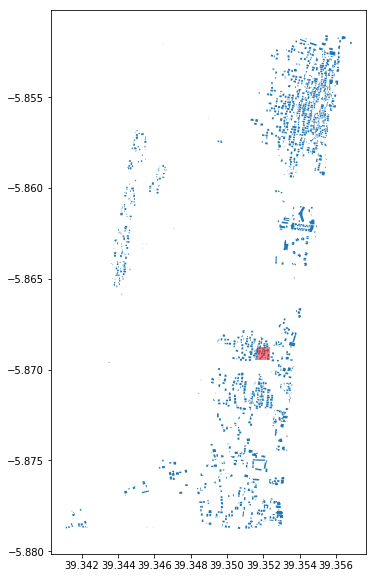

In [0]:
# visualize the tile (in red) against the entire labeled znz029 area (in blue)
fig, ax = plt.subplots(figsize=(10,10))
gt_gdf.plot(ax=ax)
gpd.GeoDataFrame(geometry=[tile_poly], crs='epsg:4326').plot(alpha=0.5, color='red', ax=ax)

In [0]:
# clip gt_gdf to the tile bounds
clipped_gt_polys = gpd.overlay(gt_gdf, gpd.GeoDataFrame(geometry=[tile_poly], crs='epsg:4326'), how='intersection')

/usr/local/lib/python3.6/dist-packages/geopandas/base.py:35: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and epsg:4326
  right.crs))


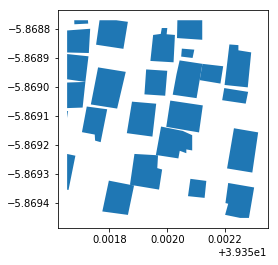

In [0]:
clipped_gt_polys.plot()

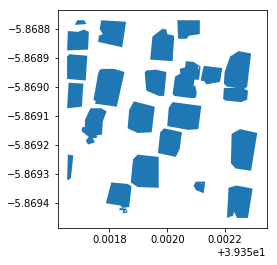

In [0]:
result_polys.plot()

In [0]:
clipped_gt_polys.to_file('clipped_gt_polys.geojson', driver='GeoJSON')

In [0]:
# solaris tutorial on evaluation: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_evaluation_tutorial.html 
evaluator = sol.eval.base.Evaluator('clipped_gt_polys.geojson')
evaluator.load_proposal('result_polys.geojson', proposalCSV=False, conf_field_list=[])
evaluator.eval_iou(calculate_class_scores=False)

23it [00:00, 165.36it/s]


[{'F1Score': 0.8749999999999999,
  'FalseNeg': 4,
  'FalsePos': 2,
  'Precision': 0.9130434782608695,
  'Recall': 0.84,
  'TruePos': 21,
  'class_id': 'all',
  'iou_field': 'iou_score_all'}]

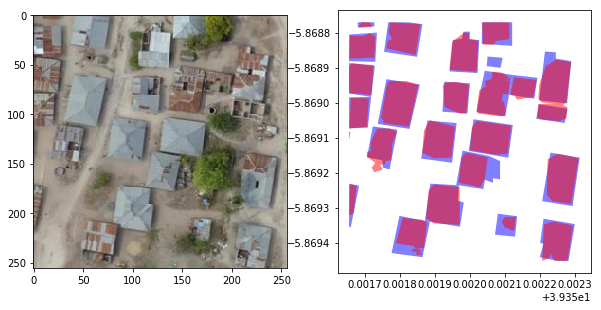

In [0]:
# visualize predicted vs ground truth
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.imshow(test_tile)
clipped_gt_polys.plot(ax=ax2, color='blue', alpha=0.5) #gt
result_polys.plot(ax=ax2, color='red', alpha=0.5) #pred

# Ideas to Try for Performance Gains

Congratulations, you did it! 

You've completed the tutorial and now know how to do everything from producing training data to creating a deep learning model for segmentation to postprocessing and evaluating your model's performance.

To flex your newfound knowledge and make your model perform potentially **much better**, try implementing some or all these ideas:

- Create and use more training data: there are 13 grids' worth of training data for Zanzibar released as part of the [Open AI Tanzania Building Footprint Segmentation Challenge dataset](https://docs.google.com/spreadsheets/d/1kHZo2KA0-VtCCcC5tL4N0SpyoxnvH7mLbybZIHZGTfE/edit#gid=0).

- Change the zoom_level of your training/validation tiles. Better yet, try using tiles across multiple zooms (i.e. z21, z20, z19, z18). Note that with multiple zoom levels over the same imagery, you should be extra careful of overlapping tiles across those different zoom levels. ← test your understanding of slippy map tiles by checking that you understand what I mean here but feel free to message me for the answer!

- Change the Unet's encoder to a bigger or different architecture (i.e. resnet50, resnet101, densenet). 

- Change the combinations, weighting, and hyperparameters of the loss functions. Or implement completely new loss functions like [Lovasz Loss](https://github.com/bermanmaxim/LovaszSoftmax).

- Try different data augmentation combinations and techniques.

- Train for more epochs and with different learning rate schedules. Try [mixed-precision](https://docs.fast.ai/callbacks.fp16.html) for faster model training. 

- Your idea here.

I look forward to seeing what you discover!

# Coming Up

If you liked this tutorial, look forward to next ones which will potentially cover topics like:
- classifying building completeness (foundation, incomplete, complete)
- inference on multiple tiles and much larger images
- working with messy, sparse, imperfect training data
- model deployment and inference at scale
- examining data/model biases, considerations of fairness, accountability, transparency, and ethics

Curious about more geospatial deep learning topics? Did I miss something? Share your questions and thoughts in the [Medium post](https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321?source=friends_link&sk=57b82002ac47724ecf9a2aaa98de994b) so I can add them into this and next tutorials. 

Good luck and happy deep learning!


# Acknowledgments and Special Thanks to

- [World Bank GFDRR](https://www.gfdrr.org/en)'s Open Data for Resilience
Initiative ([OpenDRI](https://opendri.org/)) for consultation projects which have inspired & informed.
- [Zanzibar Mapping Initiative](http://www.zanzibarmapping.com/), [OpenAerialMap](https://openaerialmap.org/), State University of Zanzibar ([SUZA](https://www.suza.ac.tz/)), Govt of Zanzibar's Commission for Lands, & [WeRobotics](https://werobotics.org/) for the [2018 Open AI Tanzania Building Footprint Segmentation Challenge](https://competitions.codalab.org/competitions/20100).
- [Fast.ai team](https://www.fast.ai/about/), [contributors](https://github.com/fastai/fastai/graphs/contributors), & [community](https://forums.fast.ai/) for both "making neural nets uncool again" and pushing its cutting edge (very cool).
- [SpaceNet](https://spacenet.ai/) & [Cosmiq Works](http://www.cosmiqworks.org/) for the open challenges, datasets, knowledge-sharing, [Solaris geoML toolkit](https://github.com/CosmiQ/solaris), & more that advance geospatial machine learning.
- Contributors to [COG](https://www.cogeo.org/), [STAC](https://stacspec.org/), and more initiatives advancing the [cloud native geospatial](https://medium.com/planet-stories/tagged/cloud-native-geospatial) ecosystem.
- [Free & open source](https://en.wikipedia.org/wiki/Free_and_open-source_software) creators & collaborators everywhere for the invaluable public goods you provide.

# Notebook Changelog

## v1 (2019-07-25):
-------
New: 1st public release

Changed: n/a

Fixed: n/a